In [1]:
import wfdb
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import seaborn as sns
import csv

from matplotlib import cm
from mne.filter import filter_data
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from mne.filter import filter_data, notch_filter
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, auc, recall_score, precision_score, f1_score, confusion_matrix, accuracy_score

import matplotlib
matplotlib.rcParams.update({'font.size':30
                            , 'font.family': 'Times New Roman'
                            , 'axes.labelsize': 30
                            , 'axes.titlesize': 30
                            , 'xtick.labelsize': 30
                            , 'ytick.labelsize': 30
                            , 'legend.fontsize': 30
                            , 'figure.titlesize': 30
                            , 'figure.dpi': 300})

all_data_path = r"PAF\coding\lj\all_data"
small_data_path = r"PAF\coding\lj\data"

# file_path = "Net1d_newGroup\PAF_net1d_Group2\list_data.h5"
# file_path = "Net1d_Split\PAF_net1d_Split1_5\list_data.h5"
firstNum = 67
file_path = f"Net1d_Split1_denoise\PAF_net1d_SplitDenoise_FirstNum-{firstNum}/list_data{firstNum}.h5"
file_paths = ["Net1d_Split1_denoise\PAF_net1d_SplitDenoise_FirstNum-16\list_data16.h5", "Net1d_Split1_denoise\PAF_net1d_SplitDenoise_FirstNum-17\list_data17.h5", "Net1d_Split1_denoise\PAF_net1d_SplitDenoise_FirstNum-43\list_data43.h5", "Net1d_Split1_denoise\PAF_net1d_SplitDenoise_FirstNum-67\list_data67.h5", "Net1d_Split1_denoise\PAF_net1d_SplitDenoise_FirstNum-103\list_data103.h5"]

hf_keys = []
data = {}
for file_path in file_paths:
    with h5py.File(file_path, 'r') as hf:
        for key in hf.keys():
            hf_keys.append(key)
            data[key] = hf[key][:]
print(hf_keys)
print(len(hf_keys))


people_info = pd.read_csv(r"PAF\coding\data_distil\people_info.csv")
key_value = people_info.set_index('Key').to_dict()['Value']
print(key_value)

['data_12_1', 'data_12_2', 'data_12_3', 'data_12_4', 'data_12_5', 'data_12_6', 'data_12_7', 'data_12_8', 'data_16_1', 'data_16_2', 'data_16_3', 'data_16_4', 'data_22_1', 'data_22_10', 'data_22_11', 'data_22_12', 'data_22_13', 'data_22_14', 'data_22_15', 'data_22_16', 'data_22_2', 'data_22_3', 'data_22_4', 'data_22_5', 'data_22_6', 'data_22_7', 'data_22_8', 'data_22_9', 'data_26_1', 'data_26_10', 'data_26_11', 'data_26_12', 'data_26_13', 'data_26_2', 'data_26_3', 'data_26_4', 'data_26_5', 'data_26_6', 'data_26_7', 'data_26_8', 'data_26_9', 'data_36_1', 'data_36_2', 'data_36_3', 'data_36_4', 'data_36_5', 'data_36_6', 'data_36_7', 'data_36_8', 'data_40_1', 'data_40_2', 'data_40_3', 'data_40_4', 'data_40_5', 'data_41_1', 'data_41_10', 'data_41_11', 'data_41_12', 'data_41_13', 'data_41_14', 'data_41_2', 'data_41_3', 'data_41_4', 'data_41_5', 'data_41_6', 'data_41_7', 'data_41_8', 'data_41_9', 'data_45_1', 'data_45_10', 'data_45_2', 'data_45_3', 'data_45_4', 'data_45_5', 'data_45_6', 'data_4

# 1000个beat做一个桶，观察Af期间和其左右的概率值变化

In [2]:
# def afDurationCreate(aux, afDuration):
#     seg = []
#     for i in range(len(aux)):
#         if aux[i] == '(AFIB' or aux[i] == 'AFL':
#             seg.append(i)
#         elif aux[i] == '(N':
#             if len(seg) != 0:
#                 seg.append(i)
#             else:
#                 seg.append(i)
#                 seg.append(i)
#             # seg.append(i)
#         if i == len(aux) - 1 and len(seg) == 1:
#             seg.append(i)
#         if len(seg) == 2:
#             afDuration.append(seg)
#             seg = []
#     if len(afDuration) == 0:
#         afDuration.append([0, 0])
# def checkInAf(x, afDuration):
#     # print(afDuration)
#     try:
#         for temp in afDuration:
#             s, e = temp[0], temp[1]
#             if x >= s and x < e:
#                 return True
#         return False
#     except:
#         print(afDuration)
#         print(x)

# targets = ['data_40_1'] # 阵发性房颤
# # len(hf_keys): 1435
# for target in targets:
#     file_name = target
#     record = wfdb.rdrecord(os.path.join(all_data_path, file_name))
#     sig, fields = wfdb.rdsamp(os.path.join(all_data_path, file_name))
#     label = key_value[int(target.split('_')[1])]
#     if label == 0:
#         continue

#     annotation = wfdb.rdann(os.path.join(all_data_path, file_name), 'atr')
#     R_location = annotation.sample
#     R_symbol = annotation.symbol
#     aux = annotation.aux_note
#     p_signal = record.p_signal[:, 0]
#     p_signal = p_signal.flatten()
#     # print("R_symbol: ", R_symbol)

#     # 滤波操作
#     sfreq = 200
#     low_freq = 0.5
#     high_freq = 50.0
#     p_signal = filter_data(p_signal, sfreq, low_freq, high_freq, method='iir', verbose=False)

#     # 获得概率值
#     seg_data = data[target]
#     # print(seg_data.shape)
#     seg_pro = []
#     for i in range(len(seg_data)):
#         seg_pro.append(round(seg_data[i][-2], 2))
    
#     # AF_location = []
#     # for i in range(len(R_symbol))[10:-5]:
#     #     if R_symbol[i] != 'N':
#     #         AF_location.append(i+1)
    
#     afDuration = []
#     afDurationCreate(aux, afDuration)

#     # 概率变化情况，因只统计了N，所以要将我们的start和end转换为N的start和end
#     all_seg_pro = [0 for i in range(10)]
#     index = 0
#     for i in range(len(R_symbol))[10:-5]:
#         if R_symbol[i] == 'N':
#             all_seg_pro.append(seg_pro[index])
#             index += 1
#         else:
#             all_seg_pro.append(1)
#     # print("index: ", index)

    
#     # start最好从 10 开始
#     start = 10
#     while start < len(R_location) - 5 and start + 20 < len(R_location) - 5:
#         end = start + 20
#         # print("seg_pro: ", seg_pro[start:end])  # 每个beat预测为1的概率
#         # print("AF_location: ", AF_location) # 标签为非"N"的位置
#         # print("R_location: ", R_location[start:end])  # R峰位置，因为从10开始开始收集数据，所以start=10
#         # print("R_symbol: ", R_symbol[start:end])  # R峰标签
#         # print("all_seg_pro: ", all_seg_pro[start:end])
#         # print()

#         start_p_signal = R_location[start]
#         end_p_signal = R_location[end]
#         plt.figure(figsize=(20, 10))
#         plt.subplot(211)
#         # plt.xlim(start_p_signal-100, end_p_signal+100)
#         plt.plot(range(start_p_signal, end_p_signal), p_signal[start_p_signal:end_p_signal])

#         # 标记R_symbol
#         index_list = [i for i in range(start, end+1)]
#         for i in index_list:
#             symbol = R_symbol[i]
#             proba = all_seg_pro[i]
#             mid_idx = R_location[i]
#             aux_note = aux[i]
#             plt.text(mid_idx, p_signal[mid_idx], symbol, fontsize=20, color='r', ha='center', va='center')
#             proba_loc = 0
#             if p_signal[mid_idx] > 0 :
#                 proba_loc = p_signal[mid_idx] - 0.1
#             else:
#                 proba_loc = p_signal[mid_idx] + 0.1
#             plt.text(mid_idx, proba_loc, proba, fontsize=20, color='r', ha='center', va='center')

#             # 标记是否属于AF片段
#             aux_loc = 0
#             if p_signal[mid_idx] > 0 :
#                 aux_loc = p_signal[mid_idx] - 0.2
#             else:
#                 aux_loc = p_signal[mid_idx] + 0.2
#             if checkInAf(i, afDuration):
#                 plt.text(mid_idx, aux_loc, "AF", fontsize=20, color='red', ha='center', va='center')
#             else:
#                 plt.text(mid_idx, aux_loc, 'NN', fontsize=20, color='black', ha='center', va='center')
#         # plt.scatter(R_location[start:end], p_signal[R_location[start:end]], c='r')
#         # plt.title(f"{target}---{start}_{end}", fontsize=15)
        
#         plt.subplot(212)
#         plt.plot(range(start, end), all_seg_pro[start:end], c='red')

#         # Normalize the values
#         norm = plt.Normalize(0, 1)
#         norm_values = norm(all_seg_pro[start:end])
#         # Choose a colormap
#         map_vir = cm.get_cmap(name='Blues')
#         # Assign colors based on values
#         colors = map_vir(norm_values)
#         # Find indices where all_seg_pro is equal to 1
#         indices_to_change = np.where(np.array(all_seg_pro[start:end]) == 1)[0]
#         # Change the color of bars with all_seg_pro == 1 to red
#         for index in indices_to_change:
#             colors[index] = [1, 0, 0, 1]  # RGBA format for red
#         # Create the bar chart
#         plt.bar(range(start, end), all_seg_pro[start:end], color=colors, label='Bar Chart')
#         # Add colorbar
#         sm = cm.ScalarMappable(cmap=map_vir, norm=norm)
#         sm.set_array([])
#         # plt.colorbar(sm)
#         plt.ylabel('Probability', fontsize=15)
#         plt.ylim(0, 1)

#         plt.tight_layout()
#         if not os.path.exists("DenoiseResultAf"):
#             os.makedirs("DenoiseResultAf")
#         plt.savefig(f"DenoiseResultAf/{target}---{start}_{end}.png")
#         plt.close()
#         start += 20

In [4]:
# def afDurationCreate(aux, afDuration):
#     seg = []
#     for i in range(len(aux)):
#         if aux[i] == '(AFIB' or aux[i] == 'AFL':
#             seg.append(i)
#         elif aux[i] == '(N':
#             if len(seg) != 0:
#                 seg.append(i)
#             else:
#                 seg.append(i)
#                 seg.append(i)
#             # seg.append(i)
#         if i == len(aux) - 1 and len(seg) == 1:
#             seg.append(i)
#         if len(seg) == 2:
#             afDuration.append(seg)
#             seg = []
#     if len(afDuration) == 0:
#         afDuration.append([0, 0])
# def checkInAf(x, afDuration):
#     # print(afDuration)
#     try:
#         for temp in afDuration:
#             s, e = temp[0], temp[1]
#             if x >= s and x < e:
#                 return True
#         return False
#     except:
#         print(afDuration)
#         print(x)

# # targets = ['data_31_14'] # 阵发性房颤:40_1, 31_1, 31_2, 31_6, 31_7, 31_10\11\12\13\14, 39也是
# # len(hf_keys): 1435
# targets = [f"data_39_{i}" for i in range(1, 23)]
# for target in targets:
#     file_name = target
#     record = wfdb.rdrecord(os.path.join(all_data_path, file_name))
#     sig, fields = wfdb.rdsamp(os.path.join(all_data_path, file_name))
#     label = key_value[int(target.split('_')[1])]
#     if label == 0:
#         continue

#     annotation = wfdb.rdann(os.path.join(all_data_path, file_name), 'atr')
#     R_location = annotation.sample
#     R_symbol = annotation.symbol
#     aux = annotation.aux_note
#     p_signal = record.p_signal[:, 0]
#     p_signal = p_signal.flatten()
#     # print("R_symbol: ", R_symbol)

#     # 滤波操作
#     sfreq = 200
#     low_freq = 0.5
#     high_freq = 50.0
#     p_signal = filter_data(p_signal, sfreq, low_freq, high_freq, method='iir', verbose=False)

#     # 获得概率值
#     seg_data = data[target]
#     # print(seg_data.shape)
#     seg_pro = []
#     for i in range(len(seg_data)):
#         seg_pro.append(round(seg_data[i][-2], 2))
    
#     # AF_location = []
#     # for i in range(len(R_symbol))[10:-5]:
#     #     if R_symbol[i] != 'N':
#     #         AF_location.append(i+1)
    
#     afDuration = []
#     afDurationCreate(aux, afDuration)

#     # 概率变化情况，因只统计了N，所以要将我们的start和end转换为N的start和end
#     all_seg_pro = [0 for i in range(10)]
#     index = 0
#     for i in range(len(R_symbol))[10:-5]:
#         if R_symbol[i] == 'N':
#             all_seg_pro.append(seg_pro[index])
#             index += 1
#         else:
#             all_seg_pro.append(1)
#     # print("index: ", index)
    
#     #  splitNum个beat分桶
#     splitNum = len(R_symbol) // 20
#     areasplitNum = [[] for i in range(len(R_symbol) // splitNum + 1)]
#     index = 0
#     for i in range(len(R_symbol))[10:-5]:
#         if R_symbol[i] == 'N':
#             areasplitNum[i // splitNum].append(seg_pro[index])
#             index += 1
    
#     avgsplitNum = []
#     for i in range(len(areasplitNum)):
#         avgsplitNum.append(np.mean(areasplitNum[i]))
#     print("len(avgsplitNum): ", len(avgsplitNum))
#     print("avgsplitNum: ", avgsplitNum)

#     try:
#         afStart = aux.index('(AFIB') // splitNum
#         afEnd = aux.index('(N') // splitNum
#         print("afStart: ", afStart)
#         print("afEnd: ", afEnd)
#     except:
#         pass
    
#     # plot画出柱状图
#     plt.figure(figsize=(20, 10))
#     # Normalize the values  
#     norm = plt.Normalize(0, 1)
#     norm_values = norm(avgsplitNum)
#     # Choose a colormap
#     map_vir = cm.get_cmap(name='Reds')
#     # Assign colors based on values
#     colors = map_vir(norm_values)
#     # Create the bar chart
#     plt.bar(range(len(avgsplitNum)), avgsplitNum, color=colors)
#     # Add colorbar
#     sm = cm.ScalarMappable(cmap=map_vir, norm=norm)
#     sm.set_array([])
#     # plt.colorbar(sm)
#     plt.ylabel('Probability', fontsize=15)
#     plt.tight_layout()
#     if not os.path.exists("DenoiseResult/afBeatProChange"):
#         os.makedirs("DenoiseResult/afBeatProChange")
#     plt.savefig(f"DenoiseResult/afBeatProChange/afBeatProChange_{target}.png")
#     plt.close()

afDuration:  [[37, 78], [299, 307]]


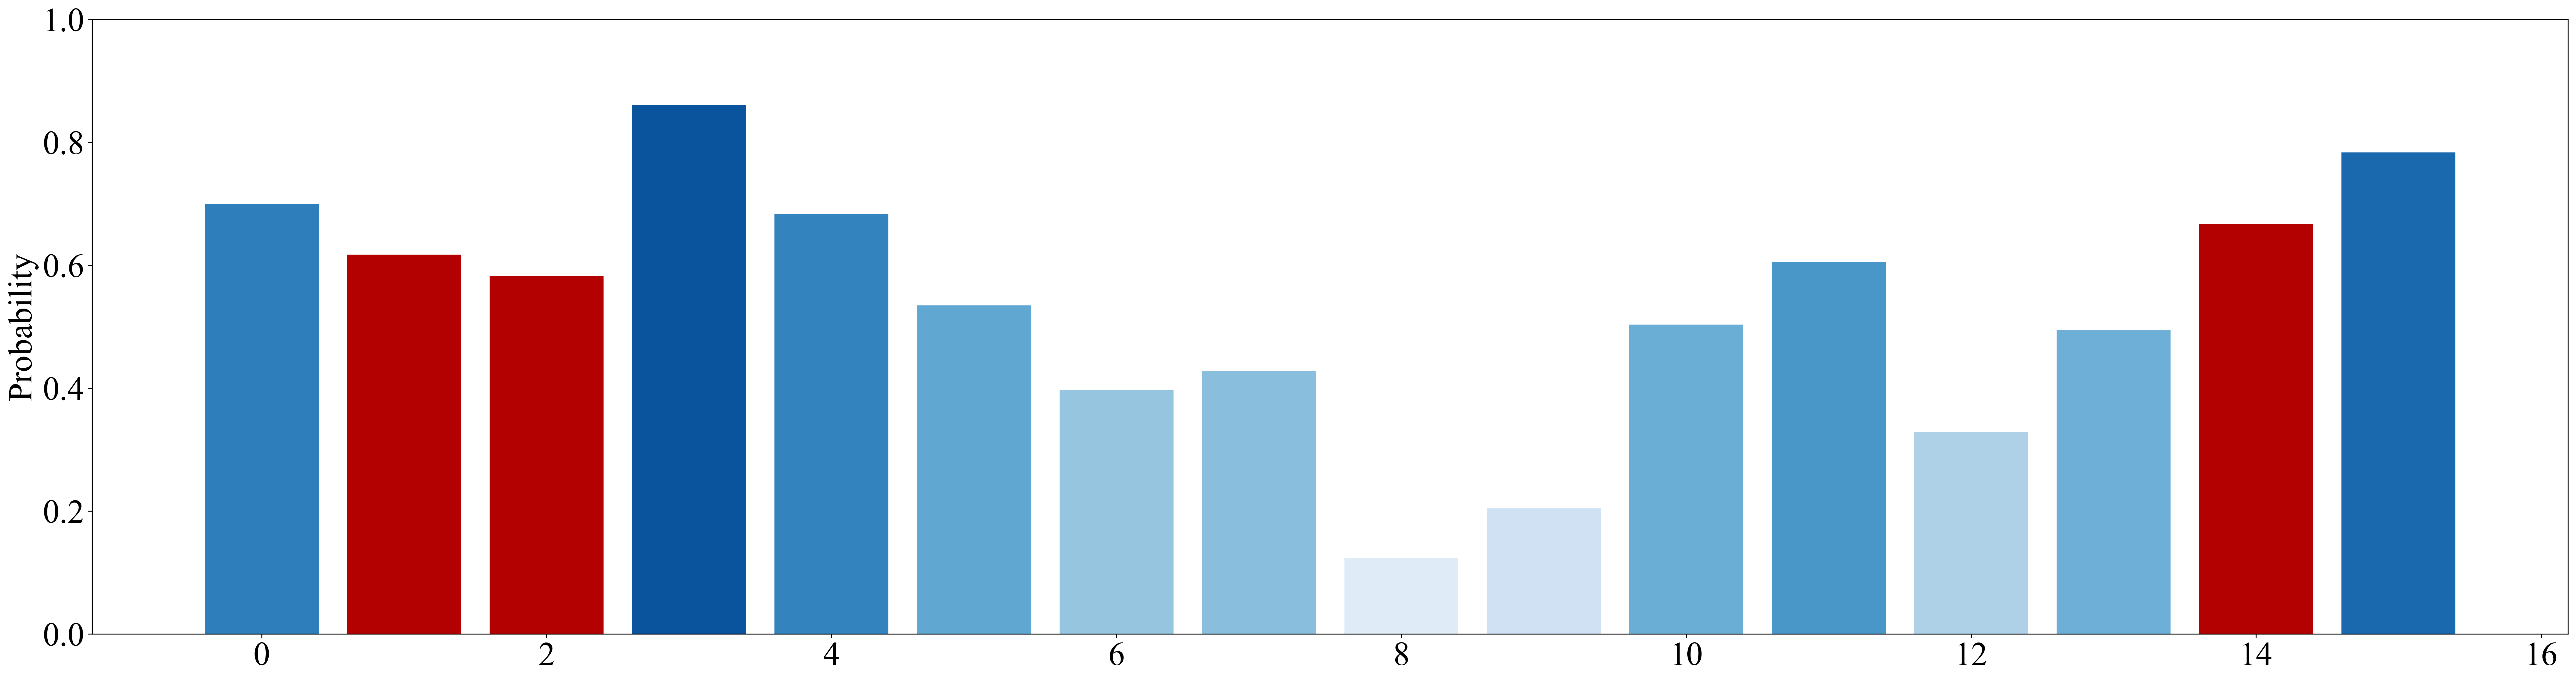

In [49]:
def afDurationCreate(aux, afDuration):
    seg = []
    for i in range(len(aux)):
        if aux[i] == '(AFIB' or aux[i] == 'AFL':
            if len(seg) == 0:
                seg.append(i)
            else:
                continue
        elif aux[i] == '(N':
            if len(seg) != 0:
                seg.append(i)
            else:
                seg.append(i)
                seg.append(i)
            # seg.append(i)
        if i == len(aux) - 1 and len(seg) == 1:
            seg.append(i)
        if len(seg) == 2:
            afDuration.append(seg)
            seg = []
    if len(afDuration) == 0:
        afDuration.append([0, 0])
def checkInAf(x, afDuration):
    # print(afDuration)
    try:
        for temp in afDuration:
            s, e = temp[0], temp[1]
            if x >= s and x < e:
                return True
        return False
    except:
        print(afDuration)
        print(x)

# targets = ['data_40_1'] # 阵发性房颤:40_1, 31_1, 31_2, 31_6, 31_7, 31_10\11\12\13\14, 39也是
# targets = [f"data_31_{i}" for i in [1, 2, 6, 7, 10, 11, 12, 13, 14]]
# testSet = [4, 11, 17, 18, 29, 30, 31, 37, 48, 75, 77, 83, 84, 86, 88, 93, 95, 97, 100, 102, 104]
testSet1 = [16, 62, 12, 22, 71, 85, 53, 69, 26, 70, 5, 40, 41, 55, 47, 36, 78, 89, 45, 8, 79]
testSet2 = [17, 31, 100, 93, 102, 95, 84, 86, 18, 11, 48, 97, 88, 83, 104, 30, 29, 75, 4, 77, 37]
testSet3 = [43, 1, 49, 72, 25, 73, 44, 76, 7, 66, 32, 46, 42, 21, 14, 63, 94, 87, 33, 19, 74]
testSet4 = [67, 15, 61, 96, 24, 9, 59, 91, 6, 0, 65, 81, 10, 20, 82, 99, 92, 35, 101, 27, 52]
testSet5 = [103, 50, 64, 28, 68, 80, 90, 51, 98, 39, 3, 56, 58, 60, 54, 34, 38, 23, 13, 2, 57]
# len(hf_keys): 1435
# targets = [f"data_39_{i}" for i in range(1, 23)]
# targets = ['data_88_4']
# targets = ['data_25_19']
targets = ['data_96_1']
for target in targets:
    # if int(target.split('_')[1]) not in [96]:
    #     continue
    file_name = target
    record = wfdb.rdrecord(os.path.join(all_data_path, file_name))
    sig, fields = wfdb.rdsamp(os.path.join(all_data_path, file_name))
    label = key_value[int(target.split('_')[1])]
    if label == 0:
        continue

    annotation = wfdb.rdann(os.path.join(all_data_path, file_name), 'atr')
    R_location = annotation.sample
    R_symbol = annotation.symbol
    aux = annotation.aux_note
    p_signal = record.p_signal[:, 0]
    p_signal = p_signal.flatten()
    # print("R_symbol: ", R_symbol)

    # 滤波操作
    sfreq = 200
    low_freq = 0.5
    high_freq = 50.0
    p_signal = filter_data(p_signal, sfreq, low_freq, high_freq, method='iir', verbose=False)

    # 获得概率值
    seg_data = data[target]
    # print(seg_data.shape)
    seg_pro = []
    for i in range(len(seg_data)):
        seg_pro.append(round(seg_data[i][-2], 2))
    
    # AF_location = []
    # for i in range(len(R_symbol))[10:-5]:
    #     if R_symbol[i] != 'N':
    #         AF_location.append(i+1)
    
    afDuration = []
    afDurationCreate(aux, afDuration)

    # 概率变化情况，因只统计了N，所以要将我们的start和end转换为N的start和end
    all_seg_pro = [0 for i in range(10)]
    index = 0
    for i in range(len(R_symbol))[10:-5]:
        if R_symbol[i] == 'N':
            all_seg_pro.append(seg_pro[index])
            index += 1
        else:
            all_seg_pro.append(1)
    # print("index: ", index)
    
    #  splitNum个beat分桶
    # tonNum = 20
    # splitNum = len(R_symbol) // tonNum
    splitNum = 20
    if splitNum == 0:
        splitNum = 1
    areasplitNum = [[] for i in range(len(R_symbol) // splitNum + 1)]
    index = 0
    for i in range(len(R_symbol))[10:-5]:
        if R_symbol[i] == 'N':
            areasplitNum[i // splitNum].append(seg_pro[index])
            index += 1
    
    avgsplitNum = []
    for i in range(len(areasplitNum)):
        avgsplitNum.append(np.mean(areasplitNum[i]))
    # print("len(avgsplitNum): ", len(avgsplitNum))
    # print("avgsplitNum: ", avgsplitNum)

    indices_to_change = []
    try:
        for temp in afDuration:
            afStart, afEnd = temp[0], temp[1]
            afStart = afStart // splitNum
            afEnd = afEnd // splitNum
            if afStart == afEnd and label == 1 and afStart != 0:
                afEnd += 1
            indices_to_change.extend(range(afStart, afEnd))
        # print("len(R_symbol): ", len(R_symbol))
        print("afDuration: ", afDuration)
    except:
        pass
    
    # plot画出柱状图
    plt.figure(figsize=(40, 10))
    # Normalize the values  
    norm = plt.Normalize(0, 1)
    norm_values = norm(avgsplitNum)
    # Choose a colormap
    map_vir = cm.get_cmap(name='Blues')
    # Assign colors based on values
    colors = map_vir(norm_values)
    # Find indices where all_seg_pro is equal to 1
    # indices_to_change = np.where(np.array(all_seg_pro[start:end]) == 1)[0]
    # Change the color of bars with all_seg_pro == 1 to red
    for index in indices_to_change:
        colors[index] = [0.7, 0, 0, 1]  # RGBA format for red
    # Create the bar chart
    plt.bar(range(len(avgsplitNum)), avgsplitNum, color=colors)
    plt.ylim(0, 1)
    # Add colorbar
    sm = cm.ScalarMappable(cmap=map_vir, norm=norm)
    sm.set_array([])
    # plt.colorbar(sm)
    plt.ylabel('Probability')
    # plt.tight_layout()
    # if not os.path.exists("DenoiseResult/afBeatProChange"):
    #     os.makedirs("DenoiseResult/afBeatProChange")
    # plt.savefig(f"DenoiseResult/afBeatProChange/afBeatProChange_{target}.png")
    # plt.close()


# ECG绘制

In [47]:
from matplotlib import cm
from matplotlib.collections import LineCollection


def afDurationCreate(aux, afDuration):
    seg = []
    for i in range(len(aux)):
        if aux[i] == '(AFIB' or aux[i] == 'AFL':
            if len(seg) == 0:
                seg.append(i)
            else:
                continue
        elif aux[i] == '(N':
            if len(seg) != 0:
                seg.append(i)
            else:
                seg.append(i)
                seg.append(i)
            # seg.append(i)
        if i == len(aux) - 1 and len(seg) == 1:
            seg.append(i)
        if len(seg) == 2:
            afDuration.append(seg)
            seg = []
    if len(afDuration) == 0:
        afDuration.append([0, 0])
def checkInAf(x, afDuration):
    # print(afDuration)
    try:
        for temp in afDuration:
            s, e = temp[0], temp[1]
            if x >= s and x < e:
                return True
        return False
    except:
        print(afDuration)
        print(x)

# targets = ['data_40_1'] # 阵发性房颤:40_1, 31_1, 31_2, 31_6, 31_7, 31_10\11\12\13\14, 39也是
# targets = [f"data_31_{i}" for i in [1, 2, 6, 7, 10, 11, 12, 13, 14]]
# testSet = [4, 11, 17, 18, 29, 30, 31, 37, 48, 75, 77, 83, 84, 86, 88, 93, 95, 97, 100, 102, 104]
testSet1 = [16, 62, 12, 22, 71, 85, 53, 69, 26, 70, 5, 40, 41, 55, 47, 36, 78, 89, 45, 8, 79]
testSet2 = [17, 31, 100, 93, 102, 95, 84, 86, 18, 11, 48, 97, 88, 83, 104, 30, 29, 75, 4, 77, 37]
testSet3 = [43, 1, 49, 72, 25, 73, 44, 76, 7, 66, 32, 46, 42, 21, 14, 63, 94, 87, 33, 19, 74]
testSet4 = [67, 15, 61, 96, 24, 9, 59, 91, 6, 0, 65, 81, 10, 20, 82, 99, 92, 35, 101, 27, 52]
testSet5 = [103, 50, 64, 28, 68, 80, 90, 51, 98, 39, 3, 56, 58, 60, 54, 34, 38, 23, 13, 2, 57]
# len(hf_keys): 1435
# targets = [f"data_39_{i}" for i in range(1, 23)]
# targets = ['data_88_4']
targets = ['data_96_1']
# targets = ['data_25_19']
for target in targets:
    # if int(target.split('_')[1]) not in [96]:
    #     continue
    file_name = target
    record = wfdb.rdrecord(os.path.join(all_data_path, file_name))
    sig, fields = wfdb.rdsamp(os.path.join(all_data_path, file_name))
    label = key_value[int(target.split('_')[1])]
    if label == 0:
        continue

    annotation = wfdb.rdann(os.path.join(all_data_path, file_name), 'atr')
    R_location = annotation.sample
    R_symbol = annotation.symbol
    aux = annotation.aux_note
    p_signal = record.p_signal[:, 0]
    p_signal = p_signal.flatten()
    # print("R_symbol: ", R_symbol)

    # 滤波操作
    sfreq = 200
    low_freq = 0.5
    high_freq = 50.0
    p_signal = filter_data(p_signal, sfreq, low_freq, high_freq, method='iir', verbose=False)

    # 获得概率值
    seg_data = data[target]
    # print(seg_data.shape)
    seg_pro = []
    for i in range(len(seg_data)):
        seg_pro.append(round(seg_data[i][-2], 2))
    
    AF_location = []
    # for i in range(len(R_symbol))[10:-5]:
    #     if R_symbol[i] != 'N':
    #         AF_location.append(i+1)
    
    afDuration = []
    afDurationCreate(aux, afDuration)

    # 概率变化情况，因只统计了N，所以要将我们的start和end转换为N的start和end
    all_seg_pro = [0 for i in range(10)]
    index = 0
    for i in range(len(R_symbol))[10:-5]:
        if R_symbol[i] == 'N':
            all_seg_pro.append(seg_pro[index])
            index += 1
        else:
            all_seg_pro.append(1)
    # print("index: ", index)
    
    #  splitNum个beat分桶
    # tonNum = 20
    # splitNum = len(R_symbol) // tonNum
    splitNum = 20
    if splitNum == 0:
        splitNum = 1
    areasplitNum = [[] for i in range(len(R_symbol) // splitNum + 1)]
    index = 0
    for i in range(len(R_symbol))[10:-5]:
        if R_symbol[i] == 'N':
            areasplitNum[i // splitNum].append(seg_pro[index])
            index += 1
    
    avgsplitNum = []
    for i in range(len(areasplitNum)):
        avgsplitNum.append(np.mean(areasplitNum[i]))
    # print("len(avgsplitNum): ", len(avgsplitNum))
    # print("avgsplitNum: ", avgsplitNum)

    indices_to_change = []
    Ecg_to_change = []
    try:
        for temp in afDuration:
            afStart, afEnd = temp[0], temp[1]
            afStart = afStart // splitNum
            afEnd = afEnd // splitNum
            if afStart == afEnd and label == 1 and afStart != 0:
                afEnd += 1
            indices_to_change.extend(range(afStart, afEnd))
            # print(range(temp[0], temp[1]))
            Ecg_to_change.append(range(R_location[temp[0]], R_location[temp[1]]))
        # print("len(R_symbol): ", len(R_symbol))
        print(f"{target} afDuration: {afDuration}")
        print(f"{target} len(Ecg_to_change): {len(Ecg_to_change)}")
    except:
        pass
    

    # 创建画布和坐标轴
    fig, ax = plt.subplots(figsize=(40, 10))
    
    # 画出原始线条
    ax.plot(p_signal, 'b', linewidth=2)

    for i in range(len(Ecg_to_change)):
        ax.plot(Ecg_to_change[i], p_signal[Ecg_to_change[i]], 'r', linewidth=2)

    plt.tight_layout()
    if not os.path.exists("DenoiseResult/ECGProChange"):
        os.makedirs("DenoiseResult/ECGProChange")
    plt.savefig(f"DenoiseResult/ECGProChange/Ecg_{target}.png")
    plt.close()

data_96_1 afDuration: [[37, 78], [299, 307]]
data_96_1 len(Ecg_to_change): 2


# 合并曲线图和柱状图

In [7]:
from matplotlib import cm
from matplotlib.collections import LineCollection


def afDurationCreate(aux, afDuration):
    seg = []
    for i in range(len(aux)):
        if aux[i] == '(AFIB' or aux[i] == 'AFL':
            if len(seg) == 0:
                seg.append(i)
            else:
                continue
        elif aux[i] == '(N':
            if len(seg) != 0:
                seg.append(i)
            else:
                seg.append(i)
                seg.append(i)
            # seg.append(i)
        if i == len(aux) - 1 and len(seg) == 1:
            seg.append(i)
        if len(seg) == 2:
            afDuration.append(seg)
            seg = []
    if len(afDuration) == 0:
        afDuration.append([0, 0])
def checkInAf(x, afDuration):
    # print(afDuration)
    try:
        for temp in afDuration:
            s, e = temp[0], temp[1]
            if x >= s and x < e:
                return True
        return False
    except:
        print(afDuration)
        print(x)

# targets = ['data_40_1'] # 阵发性房颤:40_1, 31_1, 31_2, 31_6, 31_7, 31_10\11\12\13\14, 39也是
# targets = [f"data_31_{i}" for i in [1, 2, 6, 7, 10, 11, 12, 13, 14]]
# testSet = [4, 11, 17, 18, 29, 30, 31, 37, 48, 75, 77, 83, 84, 86, 88, 93, 95, 97, 100, 102, 104]
testSet1 = [16, 62, 12, 22, 71, 85, 53, 69, 26, 70, 5, 40, 41, 55, 47, 36, 78, 89, 45, 8, 79]
testSet2 = [17, 31, 100, 93, 102, 95, 84, 86, 18, 11, 48, 97, 88, 83, 104, 30, 29, 75, 4, 77, 37]
testSet3 = [43, 1, 49, 72, 25, 73, 44, 76, 7, 66, 32, 46, 42, 21, 14, 63, 94, 87, 33, 19, 74]
testSet4 = [67, 15, 61, 96, 24, 9, 59, 91, 6, 0, 65, 81, 10, 20, 82, 99, 92, 35, 101, 27, 52]
testSet5 = [103, 50, 64, 28, 68, 80, 90, 51, 98, 39, 3, 56, 58, 60, 54, 34, 38, 23, 13, 2, 57]
# len(hf_keys): 1435
# targets = [f"data_39_{i}" for i in range(1, 23)]
# targets = ['data_88_4']
# targets = ['data_96_1']
# targets = ['data_25_19']
for target in hf_keys:
    if int(target.split('_')[1]) not in testSet4:
        continue
    file_name = target
    record = wfdb.rdrecord(os.path.join(all_data_path, file_name))
    sig, fields = wfdb.rdsamp(os.path.join(all_data_path, file_name))
    label = key_value[int(target.split('_')[1])]
    if label == 0:
        continue

    annotation = wfdb.rdann(os.path.join(all_data_path, file_name), 'atr')
    R_location = annotation.sample
    R_symbol = annotation.symbol
    aux = annotation.aux_note
    p_signal = record.p_signal[:, 0]
    p_signal = p_signal.flatten()
    # print("R_symbol: ", R_symbol)

    # 滤波操作
    sfreq = 200
    low_freq = 0.5
    high_freq = 50.0
    p_signal = filter_data(p_signal, sfreq, low_freq, high_freq, method='iir', verbose=False)

    # 获得概率值
    seg_data = data[target]
    # print(seg_data.shape)
    seg_pro = []
    for i in range(len(seg_data)):
        seg_pro.append(round(seg_data[i][-2], 2))
    
    AF_location = []
    # for i in range(len(R_symbol))[10:-5]:
    #     if R_symbol[i] != 'N':
    #         AF_location.append(i+1)
    
    afDuration = []
    afDurationCreate(aux, afDuration)

    # 概率变化情况，因只统计了N，所以要将我们的start和end转换为N的start和end
    all_seg_pro = [0 for i in range(10)]
    index = 0
    for i in range(len(R_symbol))[10:-5]:
        if R_symbol[i] == 'N':
            all_seg_pro.append(seg_pro[index])
            index += 1
        else:
            all_seg_pro.append(1)
    # print("index: ", index)
    
    #  splitNum个beat分桶
    # tonNum = 20
    # splitNum = len(R_symbol) // tonNum
    splitNum = 20
    if splitNum == 0:
        splitNum = 1
    areasplitNum = [[] for i in range(len(R_symbol) // splitNum + 1)]
    index = 0
    for i in range(len(R_symbol))[10:-5]:
        if R_symbol[i] == 'N':
            areasplitNum[i // splitNum].append(seg_pro[index])
            index += 1
    
    avgsplitNum = []
    for i in range(len(areasplitNum)):
        avgsplitNum.append(np.mean(areasplitNum[i]))
    # print("len(avgsplitNum): ", len(avgsplitNum))
    # print("avgsplitNum: ", avgsplitNum)

    indices_to_change = []
    Ecg_to_change = []
    try:
        for temp in afDuration:
            afStart, afEnd = temp[0], temp[1]
            afStart = afStart // splitNum
            afEnd = afEnd // splitNum
            if afStart == afEnd and label == 1 and afStart != 0:
                afEnd += 1
            indices_to_change.extend(range(afStart, afEnd))
            # print(range(temp[0], temp[1]))
            Ecg_to_change.append(range(R_location[temp[0]], R_location[temp[1]]))
        # print("len(R_symbol): ", len(R_symbol))
        print(f"{target} afDuration: {afDuration}")
        print(f"{target} len(Ecg_to_change): {len(Ecg_to_change)}")
    except:
        pass
    

    # 创建画布和坐标轴
    fig, ax = plt.subplots(figsize=(30, 10))
    
    ax = plt.subplot(211)
    # 画出原始线条
    ax.plot(p_signal, 'b', linewidth=2)
    for i in range(len(Ecg_to_change)):
        ax.plot(Ecg_to_change[i], p_signal[Ecg_to_change[i]], 'r', linewidth=2)

    
    ax = plt.subplot(212)
    # plot画出柱状图
    # plt.figure(figsize=(40, 10))
    # Normalize the values  
    norm = plt.Normalize(0, 1)
    norm_values = norm(avgsplitNum)
    # Choose a colormap
    map_vir = cm.get_cmap(name='Blues')
    # Assign colors based on values
    colors = map_vir(norm_values)
    # Find indices where all_seg_pro is equal to 1
    # indices_to_change = np.where(np.array(all_seg_pro[start:end]) == 1)[0]
    # Change the color of bars with all_seg_pro == 1 to red
    for index in indices_to_change:
        colors[index] = [0.7, 0, 0, 1]  # RGBA format for red
    # Create the bar chart
    ax.bar(range(len(avgsplitNum)), avgsplitNum, color=colors)
    plt.ylim(0, 1)
    # Add colorbar
    sm = cm.ScalarMappable(cmap=map_vir, norm=norm)
    sm.set_array([])
    # plt.colorbar(sm)
    plt.ylabel('Probability')

    plt.tight_layout()
    if not os.path.exists("DenoiseResult/ECGProChange"):
        os.makedirs("DenoiseResult/ECGProChange")
    plt.savefig(f"DenoiseResult/ECGProChange/Ecg_{target}.png")
    plt.close()
    

data_101_1 afDuration: [[233, 635]]
data_101_1 len(Ecg_to_change): 1
data_101_10 afDuration: [[0, 0]]
data_101_10 len(Ecg_to_change): 1
data_101_2 afDuration: [[0, 0]]
data_101_2 len(Ecg_to_change): 1
data_101_3 afDuration: [[0, 433]]
data_101_3 len(Ecg_to_change): 1
data_101_4 afDuration: [[4, 11], [42, 105], [119, 131], [146, 172], [216, 342]]
data_101_4 len(Ecg_to_change): 5


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_101_5 afDuration: [[2, 40], [59, 78], [91, 116]]
data_101_5 len(Ecg_to_change): 3


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_101_6 afDuration: [[22, 53], [72, 81], [95, 154], [189, 203]]
data_101_6 len(Ecg_to_change): 4
data_101_7 afDuration: [[2, 52], [58, 70], [96, 106], [116, 189]]
data_101_7 len(Ecg_to_change): 4
data_101_8 afDuration: [[25, 153], [186, 244]]
data_101_8 len(Ecg_to_change): 2


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_101_9 afDuration: [[21, 76]]
data_101_9 len(Ecg_to_change): 1
data_10_1 afDuration: [[0, 610]]
data_10_1 len(Ecg_to_change): 1
data_10_10 afDuration: [[0, 2552]]
data_10_10 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_10_11 afDuration: [[0, 782]]
data_10_11 len(Ecg_to_change): 1
data_10_12 afDuration: [[0, 612]]
data_10_12 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_10_13 afDuration: [[0, 802]]
data_10_13 len(Ecg_to_change): 1
data_10_14 afDuration: [[0, 232]]
data_10_14 len(Ecg_to_change): 1
data_10_2 afDuration: [[0, 815]]
data_10_2 len(Ecg_to_change): 1
data_10_3 afDuration: [[0, 550]]
data_10_3 len(Ecg_to_change): 1
data_10_4 afDuration: [[0, 792]]
data_10_4 len(Ecg_to_change): 1
data_10_5 afDuration: [[0, 767]]
data_10_5 len(Ecg_to_change): 1
data_10_6 afDuration: [[0, 1547]]
data_10_6 len(Ecg_to_change): 1
data_10_7 afDuration: [[0, 806]]
data_10_7 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_10_8 afDuration: [[0, 2802]]
data_10_8 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_10_9 afDuration: [[0, 302]]
data_10_9 len(Ecg_to_change): 1
data_24_1 afDuration: [[0, 1165]]
data_24_1 len(Ecg_to_change): 1
data_24_10 afDuration: [[0, 149]]
data_24_10 len(Ecg_to_change): 1
data_24_11 afDuration: [[0, 492]]
data_24_11 len(Ecg_to_change): 1
data_24_12 afDuration: [[0, 45]]
data_24_12 len(Ecg_to_change): 1
data_24_13 afDuration: [[0, 1708]]
data_24_13 len(Ecg_to_change): 1
data_24_14 afDuration: [[0, 249]]
data_24_14 len(Ecg_to_change): 1
data_24_15 afDuration: [[0, 632]]
data_24_15 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_24_16 afDuration: [[0, 783]]
data_24_16 len(Ecg_to_change): 1
data_24_17 afDuration: [[0, 213]]
data_24_17 len(Ecg_to_change): 1
data_24_18 afDuration: [[0, 795]]
data_24_18 len(Ecg_to_change): 1
data_24_19 afDuration: [[0, 293]]
data_24_19 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_24_2 afDuration: [[0, 302]]
data_24_2 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_24_20 afDuration: [[0, 62]]
data_24_20 len(Ecg_to_change): 1
data_24_21 afDuration: [[0, 276]]
data_24_21 len(Ecg_to_change): 1
data_24_22 afDuration: [[0, 110]]
data_24_22 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_24_23 afDuration: [[0, 380]]
data_24_23 len(Ecg_to_change): 1
data_24_24 afDuration: [[0, 173]]
data_24_24 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_24_25 afDuration: [[0, 162]]
data_24_25 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_24_26 afDuration: [[0, 44]]
data_24_26 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_24_3 afDuration: [[0, 62]]
data_24_3 len(Ecg_to_change): 1
data_24_4 afDuration: [[0, 125]]
data_24_4 len(Ecg_to_change): 1
data_24_5 afDuration: [[0, 276]]
data_24_5 len(Ecg_to_change): 1
data_24_6 afDuration: [[0, 95]]
data_24_6 len(Ecg_to_change): 1
data_24_7 afDuration: [[0, 90]]
data_24_7 len(Ecg_to_change): 1
data_24_8 afDuration: [[0, 138]]
data_24_8 len(Ecg_to_change): 1
data_24_9 afDuration: [[0, 814]]
data_24_9 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_59_1 afDuration: [[0, 344]]
data_59_1 len(Ecg_to_change): 1
data_59_10 afDuration: [[0, 770]]
data_59_10 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_59_11 afDuration: [[0, 202]]
data_59_11 len(Ecg_to_change): 1
data_59_12 afDuration: [[0, 411]]
data_59_12 len(Ecg_to_change): 1
data_59_13 afDuration: [[0, 785]]
data_59_13 len(Ecg_to_change): 1
data_59_14 afDuration: [[0, 114]]
data_59_14 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_59_15 afDuration: [[0, 902]]
data_59_15 len(Ecg_to_change): 1
data_59_16 afDuration: [[0, 418]]
data_59_16 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_59_17 afDuration: [[0, 1722]]
data_59_17 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_59_18 afDuration: [[0, 819]]
data_59_18 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_59_19 afDuration: [[0, 1263]]
data_59_19 len(Ecg_to_change): 1
data_59_2 afDuration: [[0, 432]]
data_59_2 len(Ecg_to_change): 1
data_59_20 afDuration: [[0, 458]]
data_59_20 len(Ecg_to_change): 1
data_59_21 afDuration: [[0, 431]]
data_59_21 len(Ecg_to_change): 1
data_59_22 afDuration: [[0, 453]]
data_59_22 len(Ecg_to_change): 1
data_59_23 afDuration: [[0, 416]]
data_59_23 len(Ecg_to_change): 1
data_59_24 afDuration: [[0, 450]]
data_59_24 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_59_3 afDuration: [[0, 600]]
data_59_3 len(Ecg_to_change): 1
data_59_4 afDuration: [[0, 251]]
data_59_4 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_59_5 afDuration: [[0, 1321]]
data_59_5 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_59_6 afDuration: [[0, 1161]]
data_59_6 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_59_7 afDuration: [[0, 1301]]
data_59_7 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_59_8 afDuration: [[0, 1604]]
data_59_8 len(Ecg_to_change): 1
data_59_9 afDuration: [[0, 652]]
data_59_9 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_61_1 afDuration: [[121, 264]]
data_61_1 len(Ecg_to_change): 1
data_61_2 afDuration: [[0, 0]]
data_61_2 len(Ecg_to_change): 1
data_61_3 afDuration: [[0, 0]]
data_61_3 len(Ecg_to_change): 1
data_61_4 afDuration: [[0, 0]]
data_61_4 len(Ecg_to_change): 1
data_61_5 afDuration: [[0, 0]]
data_61_5 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_61_6 afDuration: [[0, 0]]
data_61_6 len(Ecg_to_change): 1
data_61_7 afDuration: [[0, 0]]
data_61_7 len(Ecg_to_change): 1
data_61_8 afDuration: [[0, 0]]
data_61_8 len(Ecg_to_change): 1
data_65_1 afDuration: [[0, 745]]
data_65_1 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_65_10 afDuration: [[0, 959]]
data_65_10 len(Ecg_to_change): 1
data_65_11 afDuration: [[0, 611]]
data_65_11 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_65_12 afDuration: [[0, 5121]]
data_65_12 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_65_2 afDuration: [[0, 604]]
data_65_2 len(Ecg_to_change): 1
data_65_3 afDuration: [[0, 1072]]
data_65_3 len(Ecg_to_change): 1
data_65_4 afDuration: [[0, 1406]]
data_65_4 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_65_5 afDuration: [[0, 582]]
data_65_5 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_65_6 afDuration: [[0, 321]]
data_65_6 len(Ecg_to_change): 1
data_65_7 afDuration: [[0, 876]]
data_65_7 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_65_8 afDuration: [[0, 1104]]
data_65_8 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_65_9 afDuration: [[0, 820]]
data_65_9 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_67_1 afDuration: [[0, 622]]
data_67_1 len(Ecg_to_change): 1
data_67_10 afDuration: [[0, 173]]
data_67_10 len(Ecg_to_change): 1
data_67_11 afDuration: [[0, 175]]
data_67_11 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_67_12 afDuration: [[0, 699]]
data_67_12 len(Ecg_to_change): 1
data_67_13 afDuration: [[0, 169]]
data_67_13 len(Ecg_to_change): 1
data_67_14 afDuration: [[0, 258]]
data_67_14 len(Ecg_to_change): 1
data_67_15 afDuration: [[0, 98]]
data_67_15 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_67_16 afDuration: [[0, 439]]
data_67_16 len(Ecg_to_change): 1
data_67_17 afDuration: [[0, 198]]
data_67_17 len(Ecg_to_change): 1
data_67_18 afDuration: [[0, 2015]]
data_67_18 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_67_19 afDuration: [[0, 619]]
data_67_19 len(Ecg_to_change): 1
data_67_2 afDuration: [[0, 328]]
data_67_2 len(Ecg_to_change): 1
data_67_20 afDuration: [[0, 586]]
data_67_20 len(Ecg_to_change): 1
data_67_21 afDuration: [[0, 351]]
data_67_21 len(Ecg_to_change): 1
data_67_22 afDuration: [[0, 507]]
data_67_22 len(Ecg_to_change): 1
data_67_23 afDuration: [[0, 315]]
data_67_23 len(Ecg_to_change): 1
data_67_24 afDuration: [[0, 245]]
data_67_24 len(Ecg_to_change): 1
data_67_25 afDuration: [[0, 138]]
data_67_25 len(Ecg_to_change): 1
data_67_26 afDuration: [[0, 129]]
data_67_26 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_67_27 afDuration: [[0, 63]]
data_67_27 len(Ecg_to_change): 1
data_67_28 afDuration: [[0, 194]]
data_67_28 len(Ecg_to_change): 1
data_67_3 afDuration: [[0, 678]]
data_67_3 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_67_4 afDuration: [[0, 402]]
data_67_4 len(Ecg_to_change): 1
data_67_5 afDuration: [[0, 615]]
data_67_5 len(Ecg_to_change): 1
data_67_6 afDuration: [[0, 577]]
data_67_6 len(Ecg_to_change): 1
data_67_7 afDuration: [[0, 626]]
data_67_7 len(Ecg_to_change): 1
data_67_8 afDuration: [[0, 333]]
data_67_8 len(Ecg_to_change): 1
data_67_9 afDuration: [[0, 489]]
data_67_9 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_81_1 afDuration: [[0, 283]]
data_81_1 len(Ecg_to_change): 1
data_81_2 afDuration: [[0, 132]]
data_81_2 len(Ecg_to_change): 1
data_81_3 afDuration: [[0, 1527]]
data_81_3 len(Ecg_to_change): 1
data_81_4 afDuration: [[0, 633]]
data_81_4 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_81_5 afDuration: [[0, 860]]
data_81_5 len(Ecg_to_change): 1
data_81_6 afDuration: [[0, 407]]
data_81_6 len(Ecg_to_change): 1
data_81_7 afDuration: [[0, 1047]]
data_81_7 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_81_8 afDuration: [[0, 919]]
data_81_8 len(Ecg_to_change): 1
data_82_1 afDuration: [[0, 229]]
data_82_1 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_82_2 afDuration: [[0, 422]]
data_82_2 len(Ecg_to_change): 1
data_82_3 afDuration: [[0, 137]]
data_82_3 len(Ecg_to_change): 1
data_82_4 afDuration: [[0, 197]]
data_82_4 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_82_5 afDuration: [[0, 204]]
data_82_5 len(Ecg_to_change): 1
data_82_6 afDuration: [[0, 531]]
data_82_6 len(Ecg_to_change): 1
data_82_7 afDuration: [[0, 253]]
data_82_7 len(Ecg_to_change): 1
data_91_1 afDuration: [[0, 21115]]
data_91_1 len(Ecg_to_change): 1
data_91_10 afDuration: [[0, 76]]
data_91_10 len(Ecg_to_change): 1
data_91_11 afDuration: [[0, 496]]
data_91_11 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_91_12 afDuration: [[0, 1002]]
data_91_12 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_91_13 afDuration: [[0, 742]]
data_91_13 len(Ecg_to_change): 1
data_91_14 afDuration: [[0, 474]]
data_91_14 len(Ecg_to_change): 1
data_91_15 afDuration: [[0, 509]]
data_91_15 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_91_16 afDuration: [[0, 1002]]
data_91_16 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_91_17 afDuration: [[0, 502]]
data_91_17 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_91_18 afDuration: [[0, 1502]]
data_91_18 len(Ecg_to_change): 1


d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data_91_19 afDuration: [[0, 1001]]
data_91_19 len(Ecg_to_change): 1


# 增长趋势结果证明

In [6]:
def afDurationCreate(aux, afDuration):
    seg = []
    for i in range(len(aux)):
        if aux[i] == '(AFIB' or aux[i] == 'AFL':
            if len(seg) == 0:
                seg.append(i)
            else:
                continue
        elif aux[i] == '(N':
            if len(seg) != 0:
                seg.append(i)
            else:
                seg.append(i)
                seg.append(i)
            # seg.append(i)
        if i == len(aux) - 1 and len(seg) == 1:
            seg.append(i)
        if len(seg) == 2:
            afDuration.append(seg)
            seg = []
    if len(afDuration) == 0:
        afDuration.append([0, 0])
def checkInAf(x, afDuration):
    # print(afDuration)
    try:
        for temp in afDuration:
            s, e = temp[0], temp[1]
            if x >= s and x < e:
                return True
        return False
    except:
        print(afDuration)
        print(x)

# targets = ['data_40_1'] # 阵发性房颤:40_1, 31_1, 31_2, 31_6, 31_7, 31_10\11\12\13\14, 39也是
# targets = [f"data_31_{i}" for i in [1, 2, 6, 7, 10, 11, 12, 13, 14]]
testSet1 = [16, 62, 12, 22, 71, 85, 53, 69, 26, 70, 5, 40, 41, 55, 47, 36, 78, 89, 45, 8, 79]
testSet2 = [17, 31, 100, 93, 102, 95, 84, 86, 18, 11, 48, 97, 88, 83, 104, 30, 29, 75, 4, 77, 37]
testSet3 = [43, 1, 49, 72, 25, 73, 44, 76, 7, 66, 32, 46, 42, 21, 14, 63, 94, 87, 33, 19, 74]
testSet4 = [67, 15, 61, 96, 24, 9, 59, 91, 6, 0, 65, 81, 10, 20, 82, 99, 92, 35, 101, 27, 52]
testSet5 = [103, 50, 64, 28, 68, 80, 90, 51, 98, 39, 3, 56, 58, 60, 54, 34, 38, 23, 13, 2, 57]

# len(hf_keys): 1435
# targets = [f"data_39_{i}" for i in range(1, 23)]
# targets = ['data_88_4']
testSets = [testSet1, testSet2, testSet3, testSet4, testSet5]
for testSet in testSets:
    avg_labels = []
    avg_pro = []
    # 趋势证明
    trendLabel = []
    trendPredict = []
    for target in hf_keys:
        if int(target.split('_')[1]) not in testSet:
            continue
        file_name = target
        record = wfdb.rdrecord(os.path.join(all_data_path, file_name))
        sig, fields = wfdb.rdsamp(os.path.join(all_data_path, file_name))
        label = key_value[int(target.split('_')[1])]
        # if label == 0:
        #     continue

        annotation = wfdb.rdann(os.path.join(all_data_path, file_name), 'atr')
        R_location = annotation.sample
        R_symbol = annotation.symbol
        aux = annotation.aux_note
        p_signal = record.p_signal[:, 0]
        p_signal = p_signal.flatten()
        # print("R_symbol: ", R_symbol)

        # 滤波操作
        sfreq = 200
        low_freq = 0.5
        high_freq = 50.0
        p_signal = filter_data(p_signal, sfreq, low_freq, high_freq, method='iir', verbose=False)

        # 获得概率值
        seg_data = data[target]
        # print(seg_data.shape)
        seg_pro = []
        for i in range(len(seg_data)):
            seg_pro.append(round(seg_data[i][-2], 2))
        
        # AF_location = []
        # for i in range(len(R_symbol))[10:-5]:
        #     if R_symbol[i] != 'N':
        #         AF_location.append(i+1)
        
        afDuration = []
        afDurationCreate(aux, afDuration)

        # 概率变化情况，因只统计了N，所以要将我们的start和end转换为N的start和end
        all_seg_pro = [0 for i in range(10)]
        index = 0
        for i in range(len(R_symbol))[10:-5]:
            if R_symbol[i] == 'N':
                all_seg_pro.append(seg_pro[index])
                index += 1
            else:
                all_seg_pro.append(1)
        # print("index: ", index)
        
        #  splitNum个beat分桶
        # tonNum = 20
        # splitNum = len(R_symbol) // tonNum
        splitNum = 20
        if splitNum == 0:
            splitNum = 1
        areasplitNum = [[] for i in range(len(R_symbol) // splitNum + 1)]
        index = 0
        for i in range(len(R_symbol))[10:-5]:
            if R_symbol[i] == 'N':
                areasplitNum[i // splitNum].append(seg_pro[index])
                index += 1
        # print("len(areasplitNum):", len(areasplitNum))
        
        temporal = []
        avgsplitNum = []
        for i in range(len(areasplitNum)):
            # avgsplitNum.append(np.mean(areasplitNum[i]))
            if not np.isnan(np.mean(areasplitNum[i])):
                # avg_labels.append(label)
                # avg_pro.append(np.mean(areasplitNum[i]))
                temporal.append(np.mean(areasplitNum[i]))
                # print("np.mean(areasplitNum[i]): ", np.mean(areasplitNum[i]))
        # print("len(avgsplitNum): ", len(avgsplitNum))
        # print("avgsplitNum: ", avgsplitNum)


        # 趋势证明
        trendNum = 3
        for i in range(len(temporal) - trendNum):
            temp1 = temporal[i]
            temp2 = temporal[i+1]
            temp3 = temporal[i+2]
            if temp1 <= temp2 and temp2 <= temp3 and temp3 >= 0.5:
                trendPredict.append(1)
            elif temp3 >= temp1 and temp3 >= temp2 and temp3 >= 0.5:
                trendPredict.append(1)
            elif temp1 <= temp2 and temp3 <= temp2 and temp2 >= 0.5 and temp3 >= temp1:
                trendPredict.append(1)
            else:
                trendPredict.append(0)
            trendLabel.append(label)

    

    all_labels = np.array(trendLabel)
    binary_predictions = np.array(trendPredict)

    # all_probabilities = np.array(avg_pro)
    # binary_predictions = [1 if prob >= 0.5 else 0 for prob in all_probabilities]
    # print("name: ", name)
    # print("real label 1 num, 0 num: ", label.count(1), " ", label.count(0))
    # print("predict 1 num, 0 num: ", binary_predictions.count(1), " ", binary_predictions.count(0))

    acc = accuracy_score(all_labels, binary_predictions)
    recall = recall_score(all_labels, binary_predictions)
    precision = precision_score(all_labels, binary_predictions)
    f1 = f1_score(all_labels, binary_predictions)
    # auc = roc_auc_score(all_labels, all_probabilities)

    # 计算ROC曲线
    # fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    # roc_auc = auc(fpr, tpr)
    
    # 绘制ROC曲线
    # plt.figure()
    # plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic')
    # plt.legend(loc="lower right")

    # print("roc_auc_score:", roc_auc_score(all_labels, all_probabilities))
    # print("recall_score:", recall_score(all_labels, np.round(all_probabilities)))
    # print("precision_score:", precision_score(all_labels, np.round(all_probabilities)))
    # print("f1_score:", f1_score(all_labels, np.round(all_probabilities)))
    # print("confusion_matrix:\n", confusion_matrix(all_labels, np.round(all_probabilities)))
    # if not os.path.exists("./DenoiseResult/trendInterpreter"):
    #     os.makedirs("./DenoiseResult/trendInterpreter")
    # plt.tight_layout()
    # plt.savefig(f"./DenoiseResult/trendInterpreter/roc_auc{testSet[0]}.png")

    # 将结果写入CSV文件
    if not os.path.exists("./DenoiseResult/trendInterpreter"):
        os.makedirs("./DenoiseResult/trendInterpreter")
    with open(f'./DenoiseResult/trendInterpreter/splitNumAvg{splitNum}.csv', mode='a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # 如果文件不存在，写入表头
        if csvfile.tell() == 0:
            writer.writerow(['Index', 'Accuracy', 'Recall', 'Precision', 'F1', 
                            # 'AUC', 
                            'Num'])
        writer.writerow([testSet[0],
                        round(acc*100, 2), 
                        round(recall*100, 2), 
                        round(precision*100, 2), 
                        round(f1*100, 2), 
                        # round(auc*100, 2), 
                        len(all_labels)])
# 求平均值
folderPath = f"./DenoiseResult/trendInterpreter/splitNumAvg{splitNum}.csv"
df = pd.read_csv(folderPath)
avgValues = df.mean()
avgDf = pd.DataFrame({"Index": ["Avg"],
                        "Accuracy": [round(avgValues["Accuracy"], 2)],
                        "Recall": [round(avgValues['Recall'], 2)],
                        "Precision": [round(avgValues['Precision'], 2)],
                        "F1": [round(avgValues["F1"], 2)],
                        # "AUC": [round(avgValues["AUC"], 2)],
                        "Num": [round(avgValues["Num"], 2)]})
resultDf = pd.concat([df, avgDf], ignore_index=True)
resultDf.to_csv(folderPath, index=False)

d:\Anaconda\envs\shap\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
d:\Anaconda\envs\shap\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

# ECG Check

In [9]:
from collections import Counter
targets = ['data_48_6'] # 阵发性房颤
for target in targets:
    file_name = target
    record = wfdb.rdrecord(os.path.join(all_data_path, file_name))
    sig, fields = wfdb.rdsamp(os.path.join(all_data_path, file_name))
    label = key_value[int(target.split('_')[1])]

    annotation = wfdb.rdann(os.path.join(all_data_path, file_name), 'atr')
    R_location = annotation.sample
    R_symbol = annotation.symbol
    aux = annotation.aux_note
    
    p_signal = record.p_signal[:, 0]
    p_signal = p_signal.flatten()

    # 滤波操作
    sfreq = 200
    low_freq = 0.5
    high_freq = 50.0
    p_signal = filter_data(p_signal, sfreq, low_freq, high_freq, method='iir', verbose=False)

    # 获得概率值
    seg_data = data[target]
    # print(seg_data.shape)
    seg_pro = []
    for i in range(len(seg_data)):
        seg_pro.append(round(seg_data[i][-2], 2))
    print(Counter(aux))
    print("(AFIB.location: ", aux('(AFIB'))
    print("(N.location: ", aux.index('(N'))


Counter({'': 1156, '(AFIB': 3, '(N': 3})


AttributeError: 'list' object has no attribute 'find'